# EDA, Cleaning and Modeling

## Imports

In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from spacytextblob.spacytextblob import SpacyTextBlob

from spacymoji import Emoji
import sys
import string

nlp = spacy.load('en_core_web_sm')
emoji = Emoji(nlp)
nlp.add_pipe('emoji', first=True)
nlp.add_pipe('spacytextblob')

from nltk.stem import PorterStemmer


In [2]:
#pip install wordcloud
#!pip install spacymoji
#!pip install -U pip setuptools wheel
#!pip install -U spacy

CITED SOURCES:

Spent much time reviewing spaCy documentation:

https://spacy.io/usage/linguistic-features

this is a library that is currently being used for the spacymoji:

https://spacy.io/universe/project/spacymoji

https://github.com/explosion/spacymoji

https://spacy.io/api/kb

The two references below, needed a reference on groupby a bit

https://realpython.com/pandas-groupby/

https://stackoverflow.com/questions/41040132/pandas-groupby-count-and-mean-combined

Setting slice back to dataframe

https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

Quick review of the random forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/

Random Forest accurracy and metrics

https://stats.stackexchange.com/questions/197827/how-to-interpret-mean-decrease-in-accuracy-and-mean-decrease-gini-in-random-fore#:~:text=GINI%3A%20GINI%20importance%20measures%20the,increase%20nor%20decrease%20node%20purities.

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance


Some cleaning technique review, function was taken from this page: 

https://towardsdatascience.com/nlp-in-python-data-cleaning-6313a404a470

Stemming

https://stackabuse.com/python-for-nlp-tokenization-stemming-and-lemmatization-with-spacy-library/

NLTK and MultinomialNB, yes I am citing a youtube video, sorry.  Specifically the first 2 hours have portions that were helpful

https://www.youtube.com/watch?v=68lIfswwG2A

GA PCA exercise solutions:

https://git.generalassemb.ly/dsi-andromeda/pca/tree/master/exercise

GA NLP II notes:

https://git.generalassemb.ly/dsi-andromeda/nlp-ii

Save plot to file

https://stackoverflow.com/questions/9622163/save-plot-to-image-file-instead-of-displaying-it-using-matplotlib

### Function Defs

In [3]:
# https://towardsdatascience.com/nlp-in-python-data-cleaning-6313a404a470 for this function:

def punc_clean(thread):
    list_letters=[let for let in thread if let not in string.punctuation]
    clean_thread=''.join(list_letters)
    return clean_thread

#def stem_func(thread):
    

## Importing and Quick Overview

In [4]:
df_reddit=pd.read_csv('./full_data/full_data_06JAN2021_cut500.csv')

In [5]:
df_reddit.head(5)

,Unnamed: 0,comment_count,upvote_delta,timeup_list,subreddit,thread_text
0,0.0,18300.0,37200.0,15.0,r/AskReddit,People who aren’t celebrating or partying righ...
1,1.0,697.0,35800.0,3.0,r/funny,After years of saving I finally bought a house
2,2.0,189.0,19800.0,4.0,r/Showerthoughts,Beatboxers probably have no issue explaining t...
3,3.0,4300.0,48800.0,10.0,r/facepalm,“All I need to cook is a set of measuring cups...
4,5.0,998.0,20300.0,5.0,r/PoliticalHumor,Birds of a feather flock together!


In [6]:
df_reddit.drop(labels=df_reddit.columns[0],axis=1,inplace=True)

The extra index could have been used to measure the general placement of the post on the front page.

In [7]:
df_reddit.shape

(12124, 5)

Shape checks out

In [8]:
df_reddit.isnull().sum()

comment_count    0
upvote_delta     0
timeup_list      0
subreddit        0
thread_text      0
dtype: int64

In [9]:
df_reddit.dtypes

comment_count    float64
upvote_delta     float64
timeup_list      float64
subreddit         object
thread_text       object
dtype: object

Null verification and data type check.

## EDA and Cleaning

### Reviewing upvote, time up and duplicates

In [11]:
df_reddit.describe().T

,count,mean,std,min,25%,50%,75%,max
comment_count,12124.0,437.093863,1129.671966,1.0,84.0,167.0,397.0,32400.0
upvote_delta,12124.0,8787.702326,12394.935178,1.0,2000.0,4200.0,9800.0,132000.0
timeup_list,12124.0,9.654569,5.515745,2.0,6.0,9.0,13.0,228.0


In [12]:
df_reddit[df_reddit['upvote_delta']<2000].mean()

comment_count     162.298507
upvote_delta     1214.648733
timeup_list         6.806317
dtype: float64

In [13]:
df_reddit[df_reddit['upvote_delta']<350].sort_values(by='timeup_list').tail(10)

,comment_count,upvote_delta,timeup_list,subreddit,thread_text
9490,50.0,343.0,5.0,r/chicagobulls,"Nikola Vučević with 24 points, 17 rebounds, 6 ..."
9484,10.0,296.0,5.0,r/nflmemes,AFC East
9472,40.0,324.0,5.0,r/LesbianActually,Denver lesbian here! 👋🏼
9422,53.0,324.0,5.0,r/averageredditor,"Average redditor tries to fight ""fascist"""
9407,72.0,323.0,5.0,r/Boruto,Did Sasuke marry Sakura out of pity?
3044,13.0,12.0,5.0,r/politics,Invest Pre-IPO in Company with drug shown effe...
9471,3.0,303.0,5.0,r/oompasubs,Yea let me explain-
11993,41.0,334.0,12.0,r/PublicFreakout,HMC while I mistake strangers' homes as that o...
802,5.0,1.0,13.0,r/ShingekiNoKyojin,NFT investing made easy. Hop on the blockchain...
9483,7.0,202.0,19.0,r/MadeMeSmile,"Screw over Karen, help the kid"


It is my understanding that log rates of up time for the post and vote count are related to what gets pushed to the front page.

While we will see that indeed posts can get to the front page with low comments, its highly unlikely that they make it to the front page with a low amount of votes.

In [14]:
df_reddit[df_reddit['timeup_list']>24]

,comment_count,upvote_delta,timeup_list,subreddit,thread_text
964,52.0,950.0,132.0,r/greentext,anon is a dumbass
1130,297.0,7700.0,60.0,r/dumbasseswithlighters,What could go wrong trying to spit fire
1442,90.0,2000.0,84.0,r/therewasanattempt,HMFT after I try to rope swing above these rocks
1922,175.0,4900.0,108.0,r/therewasanattempt,HMFT after I try to rope swing above these rocks
1972,66.0,9800.0,60.0,r/matrixmemes,The only time I wanna see Morpheous in a bathr...
1978,63.0,6700.0,60.0,r/wholesomegifs,Had to watch it through multiple times to see ...
3263,241.0,3600.0,60.0,r/TiktokCringeTime,Teenage Girl nails movements from a game franc...
3986,119.0,736.0,228.0,r/Cringetopia,GUYS GET SOME HELP
4359,69.0,4300.0,60.0,r/funnyvideos,What did he expect?
4973,79.0,1100.0,60.0,r/antiwork,Let’s all go on strike and demand better


Going to clean out threads with long up times, threads getting 'rezzed' are not in the scope of this project.

In [15]:
print(df_reddit[df_reddit['timeup_list']>24].shape)
df_reddit=df_reddit[df_reddit['timeup_list']<=24]
df_reddit.shape

(16, 5)


(12108, 5)

Removing posts up for large amounts of time

In [16]:
df_reddit=df_reddit[df_reddit['upvote_delta']>=350]

In [17]:
df_reddit[df_reddit.duplicated(subset=['thread_text','subreddit'], keep='first')]

,comment_count,upvote_delta,timeup_list,subreddit,thread_text
510,2300.0,23900.0,15.0,r/movies,"The Big Lebowski is one of the funniest, best ..."
515,1900.0,12500.0,17.0,r/Coronavirus,The Covid-19 case surge is altering daily life...
518,1800.0,5000.0,14.0,r/CryptoCurrency,Best lifehacks in crypto that beginners should...
525,1600.0,30800.0,15.0,r/awfuleverything,It's more common in men than you think. What k...
527,1700.0,12400.0,15.0,r/gtaonline,Fuck zodiac signs.
...,...,...,...,...,...
12086,913.0,16100.0,19.0,r/Futurology,Japan Is Working on a COVID-19 Vaccine That Of...
12092,814.0,10600.0,19.0,r/unitedkingdom,Prince Andrew asked to prove his inability to ...
12114,717.0,41700.0,17.0,r/NatureIsFuckingLit,"🔥 The kakapo also known as The owl parrot, is ..."
12116,695.0,15400.0,15.0,r/insaneparents,I’m sure this 10-year-old kid made his own inf...


A quick check on the duplicates of thread text duplicates, its no surprise that some subreddits will have many threads titled similarly or even the same as the subreddit to a degree.

In [18]:
df_reddit[df_reddit.duplicated(subset=['thread_text'], keep='first')].comment_count.describe()

count      977.000000
mean       639.704197
std       1279.012794
min         10.000000
25%        127.000000
50%        272.000000
75%        650.000000
max      19700.000000
Name: comment_count, dtype: float64

In [19]:
df_reddit[df_reddit.duplicated(subset=['thread_text'], keep='last')].comment_count.describe()

count     977.000000
mean      288.131013
std       559.841090
min         3.000000
25%        64.000000
50%       124.000000
75%       278.000000
max      5900.000000
Name: comment_count, dtype: float64

Since over 10,000 posts was a target sample size, dropping duplicates is not the end of the world.

In [20]:
df_reddit[df_reddit['subreddit']=='r/me_irl'].sort_values(by='comment_count',ascending=False).head(5)

,comment_count,upvote_delta,timeup_list,subreddit,thread_text
1525,3000.0,101000.0,14.0,r/me_irl,Me_irl
11025,1900.0,65100.0,12.0,r/me_irl,me_irl
10621,852.0,63600.0,17.0,r/me_irl,me_irl
8049,787.0,31600.0,10.0,r/me_irl,me_irl
3155,652.0,43200.0,13.0,r/me_irl,me_irl


In [21]:
df_reddit[df_reddit['subreddit']=='r/me_irl'].sort_values(by='comment_count',ascending=False).tail(5)

,comment_count,upvote_delta,timeup_list,subreddit,thread_text
5400,47.0,5100.0,7.0,r/me_irl,Me_irl
9616,44.0,12600.0,7.0,r/me_irl,me_irl
11455,42.0,7300.0,8.0,r/me_irl,me🏃irl
2625,28.0,3900.0,11.0,r/me_irl,"Thanks i hate how he ""repaired"" the emoji"
11586,22.0,6600.0,7.0,r/me_irl,me_irl


In [22]:
df_reddit[(df_reddit['subreddit']=='r/me_irl') & (df_reddit['thread_text']=='me_irl')].count()

comment_count    22
upvote_delta     22
timeup_list      22
subreddit        22
thread_text      22
dtype: int64

For example, the subreddit 'me_irl' has 22 appearances in the dataset with a wide range of comment numbers.  Based on the scope of this project posts like this will probably not add meaningful insight when modeled.

In [23]:
df_reddit[(df_reddit['subreddit']=='r/maybemaybemaybe')].describe().T

,count,mean,std,min,25%,50%,75%,max
comment_count,31.0,319.516129,431.235888,14.0,78.5,154.0,375.0,2000.0
upvote_delta,31.0,13125.806452,12301.570841,2100.0,5450.0,8600.0,13550.0,55400.0
timeup_list,31.0,9.419355,4.318751,4.0,6.0,8.0,10.5,20.0


In [24]:
df_reddit[(df_reddit['subreddit']=='r/maybemaybemaybe')].head(5)

,comment_count,upvote_delta,timeup_list,subreddit,thread_text
302,27.0,2800.0,5.0,r/maybemaybemaybe,Maybe Maybe Maybe
391,89.0,2100.0,5.0,r/maybemaybemaybe,Maybe maybe maybe
678,213.0,8600.0,9.0,r/maybemaybemaybe,maybe maybe maybe
1121,278.0,11800.0,7.0,r/maybemaybemaybe,Maybe maybe Maybe
1199,381.0,19500.0,9.0,r/maybemaybemaybe,Maybe Maybe Maybe


Another example of the subreddit r/maybemaybemaybe, many of the threads are the subreddit text itself (memes and such yes)

In [25]:
df_reddit=df_reddit[~df_reddit.duplicated(subset=['thread_text'], keep='last')]

Cleaning duplicates

### EDA: General look after intial cleaning

In [26]:
print('Comment count stats-  mean:',df_reddit['comment_count'].mean(),'   median:',df_reddit['comment_count'].median())

Comment count stats-  mean: 451.24689468946895    median: 171.0


Post duplicate removal check on statistical values

In [27]:
df_reddit['comment_count'].describe()

count    11110.000000
mean       451.246895
std       1167.277686
min          1.000000
25%         87.000000
50%        171.000000
75%        408.000000
max      32400.000000
Name: comment_count, dtype: float64

Further cleaning will shift the statistical values, but its also possible that the high/low delination mark will be chosen to be mean over median.

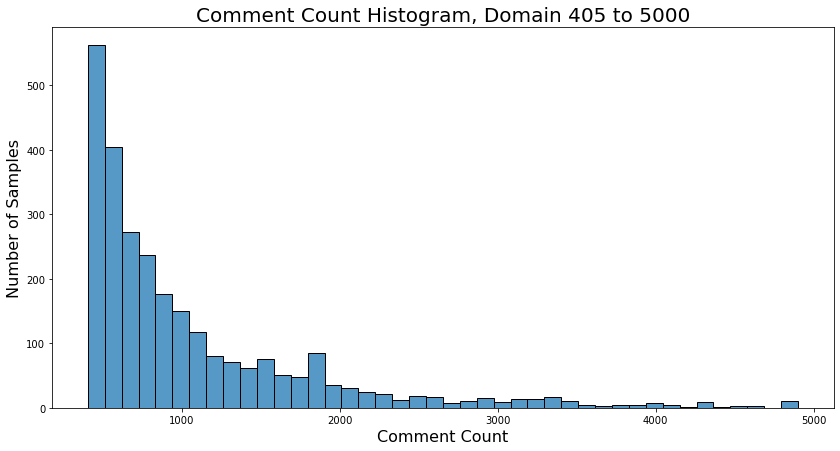

In [229]:
plt.figure(figsize = (14,7))
sns.histplot(df_reddit[(df_reddit['comment_count']>405) & (df_reddit['comment_count']<5000)],x='comment_count')
plt.title('Comment Count Histogram, Domain 405 to 5000',size=20)
plt.xlabel('Comment Count',size=16)
plt.ylabel('Number of Samples',size=16);

Good visual of how the once posts get over 2000 there is a sparse but continuous distribution of posts up until about 5000.

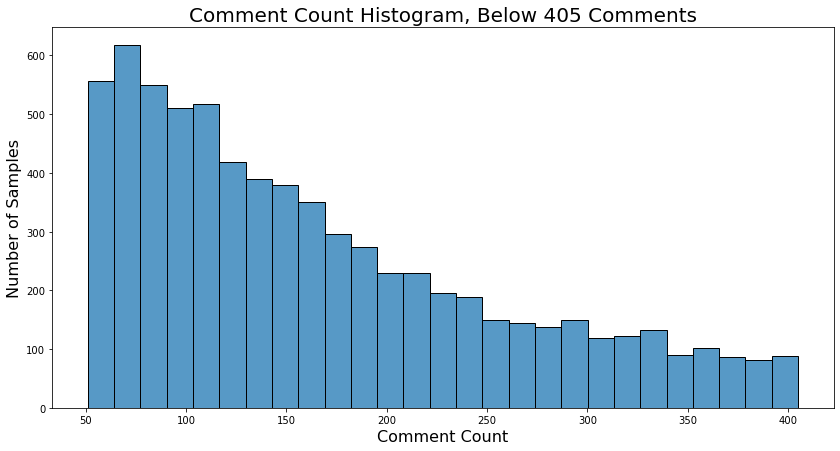

In [228]:
plt.figure(figsize = (14,7))
sns.histplot(df_reddit[(df_reddit['comment_count']<=405)],x='comment_count')
plt.title('Comment Count Histogram, Below 405 Comments',size=20)
plt.xlabel('Comment Count',size=16)
plt.ylabel('Number of Samples',size=16);

Large number of observations below 100 comment count

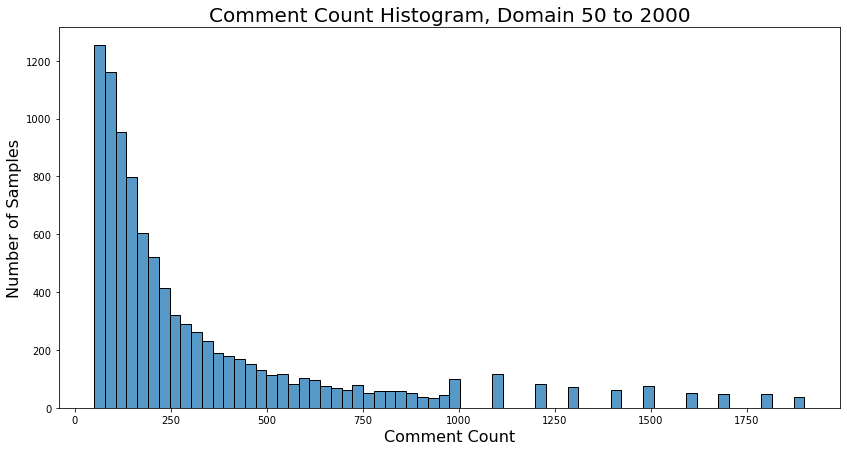

In [227]:
plt.figure(figsize = (14,7))
sns.histplot(df_reddit[(df_reddit['comment_count']>50) & (df_reddit['comment_count']<2000)],x='comment_count')
plt.title('Comment Count Histogram, Domain 50 to 2000',size=20)
plt.xlabel('Comment Count',size=16)
plt.ylabel('Number of Samples',size=16);

In [31]:
df_reddit[df_reddit['comment_count']>50].shape

(9907, 5)

In [32]:
df_reddit[(df_reddit['comment_count']>50) & (df_reddit['comment_count']<2000)].shape[0]

9502

If we drop all comments below 50 this should help remove posts that probably are not typical of front page.

In [33]:
#df_reddit.groupby('subreddit')['comment_count'].mean().nlargest(20)

In [34]:
df_reddit.groupby('subreddit')['comment_count'].count().nlargest(20)

subreddit
r/antiwork                72
r/MadeMeSmile             71
r/memes                   67
r/nextfuckinglevel        65
r/Damnthatsinteresting    64
r/interestingasfuck       61
r/Unexpected              59
r/facepalm                58
r/HolUp                   56
r/WhitePeopleTwitter      56
r/aww                     55
r/gaming                  54
r/dankmemes               52
r/funny                   52
r/Superstonk              51
r/pics                    51
r/politics                51
r/BlackPeopleTwitter      48
r/AskReddit               47
r/cats                    47
Name: comment_count, dtype: int64

r/Antiwork is a subreddit that has been gaining substaintial traction, so its no surprise it has a very high frequency in our sample set.

### EDA: No giveaways and suppress lower comment counts

In [35]:
df_reddit.groupby('thread_text').mean().sort_values(by='comment_count',ascending=False).head(20).T

thread_text,Whats criminally overpriced to you?,"Without naming it, what is a TV show that is instantly recognizable based on one quote?","Non picky eaters, what’s a food you just cannot do?","What's your ""I fucking hate this song"" song?",What tastes good hot and cold?,"To all the atheists, what is your reason for not believing in God or a higher power?",GIVEAWAY: I'm giving away Escape From Tarkov: Prepare for Escape Edition or $100 Cash to one comment in this thread,What were the dumbest lies you believed when you were a kid?,What is a survival myth that is completely wrong and could get you killed?,"If you were handed 10 billion dollars right now, what would you still never buy?","People who aren’t celebrating or partying right now, what are you doing?",Who is your celebrity crush?,Which videogame consumed your entire life upon first play-through?,GIVEAWAY: I'm giving away $100 worth of The Witcher merch to one comment in this thread,Which TV show has never had a bad episode?,NVIDIA RTX 3050 announcement + NVIDIA Q&A + RTX 3080Ti FE giveaway,What ruins a movie instantly?,What science fiction or fantasy show is worth watching?,What is a recent fashion trend that you can't stand?,"FREE SILVER GIVEAWAY on REDDIT ... 15oz of SILVER FREE !!! Just comment why you love Silver and upvote this post. We will select 6 winners. 1st place gets 10oz End The Fed bar, 5 runner-up winners will get 1 oz WSS round! Contest ends New Years Eve at Midnight eastern time! 🚀"
comment_count,32400.0,31500.0,27300.0,24800.0,23400.0,20500.0,20500.0,19700.0,18900.0,18500.0,18300.0,18100.0,17600.0,17400.0,17100.0,17000.0,16900.0,15400.0,13500.0,13300.0
upvote_delta,42300.0,27300.0,29000.0,22300.0,29100.0,21200.0,5100.0,42400.0,58900.0,27000.0,37200.0,18300.0,23000.0,4000.0,19500.0,5200.0,19100.0,29100.0,15200.0,5500.0
timeup_list,16.0,16.0,14.0,6.0,10.0,17.0,12.0,16.0,15.0,10.0,15.0,9.0,12.0,12.0,10.0,13.0,6.0,16.0,12.0,15.0


Posts sorted by comment count, showing highest reveals that give away posts have high comment counts as one would expect, but these can be removed from the data set.

In [36]:
df_reddit['give_it_away']=df_reddit['thread_text'].apply(lambda x: 1 if x.lower().find('giveaway')>=0 else 0)

In [37]:
df_reddit[df_reddit['give_it_away']==1]

,comment_count,upvote_delta,timeup_list,subreddit,thread_text,give_it_away
2003,8400.0,2700.0,4.0,r/destiny2,GIVEAWAY: I'm giving away a pre-order of Desti...,1
2521,2100.0,1600.0,5.0,r/DnD,[OC] I'm sponsoring a giveaway for all this D&...,1
3001,17000.0,5200.0,13.0,r/buildapc,NVIDIA RTX 3050 announcement + NVIDIA Q&A + RT...,1
4001,10900.0,10500.0,15.0,r/pcgaming,[GIVEAWAY] $20 Steam Gift Card,1
5001,10100.0,1000.0,7.0,r/wow,GIVEAWAY: I'm giving away a $100 Blizzard Bala...,1
5002,8100.0,1900.0,4.0,r/PS4,Giveaway: 100$ Playstation Store Gift Card to ...,1
5500,20500.0,5100.0,12.0,r/EscapefromTarkov,GIVEAWAY: I'm giving away Escape From Tarkov: ...,1
5505,7900.0,10800.0,10.0,r/pcmasterrace,[CHRISTMAS GIVEAWAY] Hello PCMasterRace! In ch...,1
5522,3500.0,2700.0,11.0,r/PokemonSwordAndShield,Christmas Giveaway! Green Shing Only! Giving a...,1
9004,17400.0,4000.0,12.0,r/witcher,GIVEAWAY: I'm giving away $100 worth of The Wi...,1


In [38]:
df_reddit[df_reddit['give_it_away']==1].comment_count.mean()

10836.363636363636

While these are not necessarily all outliers, they are all high comment counts and are similar to promotional ads (that were already removed).

**This is not to say that it isn't a good idea to use a giveaway to create comment traction for a thread**

However, they do not need to be in modeling as by inspection in EDA its a powerful language feature in relation to comment count.

In [39]:
df_reddit=df_reddit[df_reddit['give_it_away']==0]

removing the giveaways in the line above.

**Removing all comment counts below 50**

In [40]:
df_reddit=df_reddit[df_reddit['comment_count']>50]

Again these would not traditionally be seen as outliers, but in the case of reddit front page these are not great samples

In [41]:
df_reddit.shape

(9896, 6)

In [42]:
df_reddit.groupby('thread_text').mean().sort_values(by='comment_count',ascending=False).head(10)

,comment_count,upvote_delta,timeup_list,give_it_away
thread_text,,,,
Whats criminally overpriced to you?,32400.0,42300.0,16.0,0
"Without naming it, what is a TV show that is instantly recognizable based on one quote?",31500.0,27300.0,16.0,0
"Non picky eaters, what’s a food you just cannot do?",27300.0,29000.0,14.0,0
"What's your ""I fucking hate this song"" song?",24800.0,22300.0,6.0,0
What tastes good hot and cold?,23400.0,29100.0,10.0,0
"To all the atheists, what is your reason for not believing in God or a higher power?",20500.0,21200.0,17.0,0
What were the dumbest lies you believed when you were a kid?,19700.0,42400.0,16.0,0
What is a survival myth that is completely wrong and could get you killed?,18900.0,58900.0,15.0,0
"If you were handed 10 billion dollars right now, what would you still never buy?",18500.0,27000.0,10.0,0


It is pretty clear that we can already see a trend, thread titles that are questions can yield high comment counts.

In [43]:
df_reddit.drop(labels='give_it_away',axis=1,inplace=True)

The giveaway true/false column is no longer needed

In [44]:
df_reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9896 entries, 0 to 12123
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   comment_count  9896 non-null   float64
 1   upvote_delta   9896 non-null   float64
 2   timeup_list    9896 non-null   float64
 3   subreddit      9896 non-null   object 
 4   thread_text    9896 non-null   object 
dtypes: float64(3), object(2)
memory usage: 463.9+ KB


In [45]:
print('Initial Baseline metric, cleaned median:', df_reddit['comment_count'].median())

Initial Baseline metric, cleaned median: 200.0


From this we have our first baseline, median of 200 comment count.  We will create a test model around this as the initial baseline.

In [46]:
df_reddit_a=df_reddit.copy(deep=True)  #just creating a clean copy

In [47]:
df_reddit_c=df_reddit_a.copy(deep=True)

df_reddit_a will be a failsafe copy of the cleaned frame.

### EDA: Cleaning thread text and adding features, getting ready for NLP/Modeling

In [48]:
df_reddit_c['thread_text']=df_reddit_c['thread_text'].str.lower()

In [49]:
df_reddit_c['thread_text']

0        people who aren’t celebrating or partying righ...
1           after years of saving i finally bought a house
2        beatboxers probably have no issue explaining t...
3        “all i need to cook is a set of measuring cups...
4                       birds of a feather flock together!
                               ...                        
12119                     some of those who nonce foxes...
12120    paraguay now produces 100% renewable electric ...
12121                   deceptive marketing for car chases
12122                           darth maul grinning noises
12123             this f@rkwit probably doesn’t even play.
Name: thread_text, Length: 9896, dtype: object

In [50]:
df_reddit_c['question_mark']=df_reddit_c['thread_text'].apply(lambda x: 1 if x.find('?')>=0 else 0)

In [51]:
df_reddit_c[df_reddit_c['question_mark']==1].describe()

,comment_count,upvote_delta,timeup_list,question_mark
count,1157.000000,1157.000000,1157.000000,1157.0
mean,1026.601556,6660.599827,9.662921,1.0
std,2791.689510,9795.367401,4.181701,0.0
min,51.000000,350.000000,2.000000,1.0
25%,130.000000,1600.000000,6.000000,1.0
50%,287.000000,3300.000000,9.000000,1.0
75%,722.000000,7400.000000,12.000000,1.0
max,32400.000000,101000.000000,24.000000,1.0


Signficant amount of deviation around the mean, this is probably because a wide range of posts have a question mark in them.

In [52]:
df_reddit_c['thread_text_clean']=df_reddit_c['thread_text'].apply(lambda x: punc_clean(x))

removing punctuation from the thread text using the function defined earlier.

In [53]:
df_reddit_c['emoji']=df_reddit_c['thread_text_clean'].apply(lambda x: 1 if nlp(x)._.has_emoji else 0)

using a spaCy addon to detect emoji's in threads

In [54]:
#df_reddit_c['thread_text_clean']=df_reddit_c['thread_text_clean'].apply(lambda x: )

In [55]:
df_reddit_c['polarity']=df_reddit_c['thread_text_clean'].apply(lambda x: nlp(x)._.polarity)

In [56]:
df_reddit_c['subjectivity']=df_reddit_c['thread_text_clean'].apply(lambda x: nlp(x)._.subjectivity)

adding polarity and subjectivity

In [57]:
stemmer = PorterStemmer()

In [58]:
df_reddit_c['stemmed_thread'] = [' '.join([stemmer.stem(w.text) for w in nlp(t)]) for t in df_reddit_c['thread_text_clean']]

In [59]:
print('Low polarity:',round(df_reddit_c[df_reddit_c['polarity']<-0.5].comment_count.mean()),'  High polarity:',round(df_reddit_c[df_reddit_c['polarity']>0.5].comment_count.mean()))

Low polarity: 686   High polarity: 435


Both high and low polarity yield have higher comment counts vs the baseline score.

In [60]:
#df_reddit_c[df_reddit_c['polarity']<-0.5].sort_values(by='comment_count',ascending=False).head(6)

This is commented out (not nice things being said!) but it shows the lower bound of the polarity metric, controversy/negativity is good for comments/upvote count :(

In [105]:
df_reddit_c[df_reddit_c['subjectivity']<0.5].comment_count.mean()

471.6764538198404

In [61]:
# plt.figure(figsize = (20,10))
# sns.scatterplot(data=df_reddit_c[df_reddit_c['comment_count']<5000], x="polarity", y="comment_count")

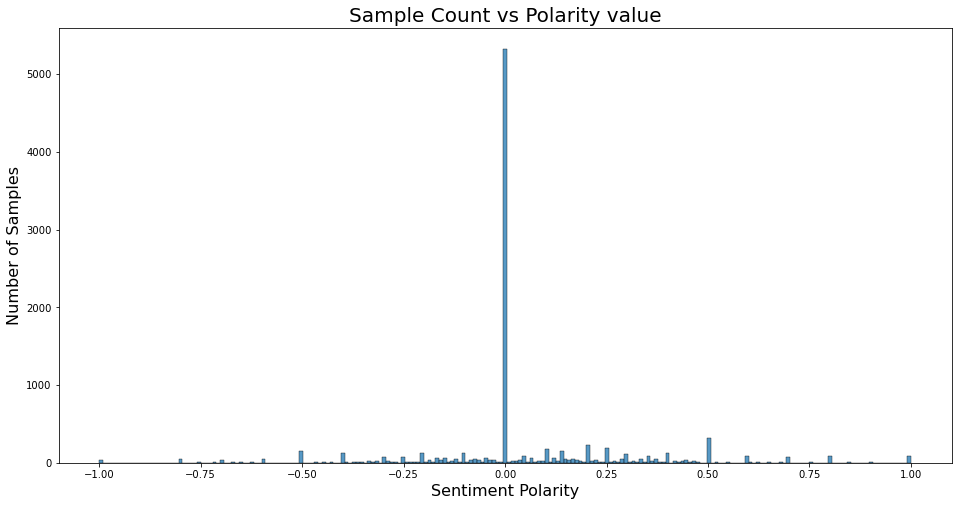

In [345]:
plt.figure(figsize = (16,8))
sns.histplot(data=df_reddit_c,x='polarity')
plt.title('Sample Count vs Polarity value',size=20)
plt.xlabel('Sentiment Polarity',size=16)
plt.ylabel('Number of Samples',size=16);

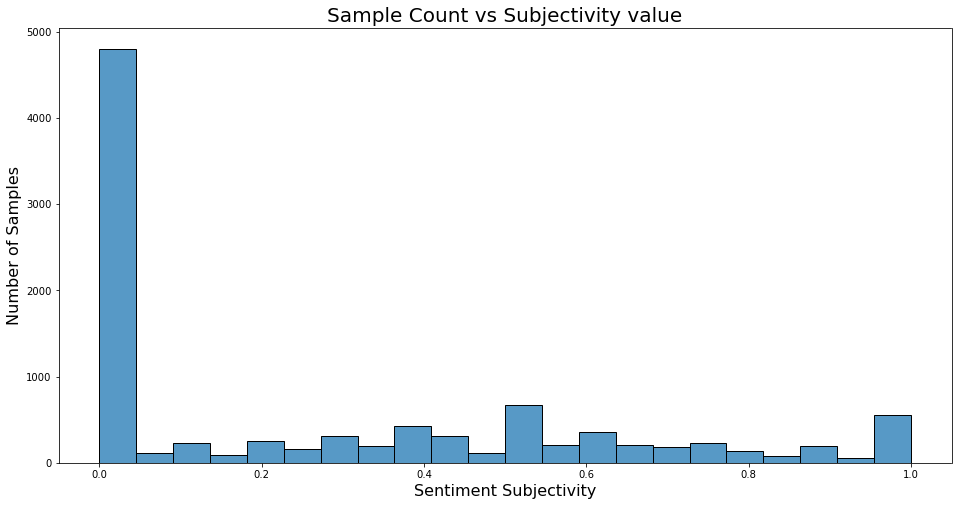

In [225]:
plt.figure(figsize = (16,8))
sns.histplot(data=df_reddit_c,x='subjectivity')
plt.title('Sample Count vs Subjectivity value',size=20)
plt.xlabel('Sentiment Subjectivity',size=16)
plt.ylabel('Number of Samples',size=16);

In [64]:
df_reddit_c['post_word_count'] = df_reddit_c['stemmed_thread'].apply(lambda x: len(x.split()))

In [65]:
df_reddit_c[df_reddit_c['post_word_count']>8].comment_count.mean()

590.3294238683128

In [339]:
df_reddit_c[(df_reddit_c['post_word_count']<20)&(df_reddit_c['post_word_count']>8)].comment_count.mean()

620.022021456804

In [66]:
df_reddit_c[df_reddit_c['post_word_count']<8].comment_count.mean()

379.8024129296608

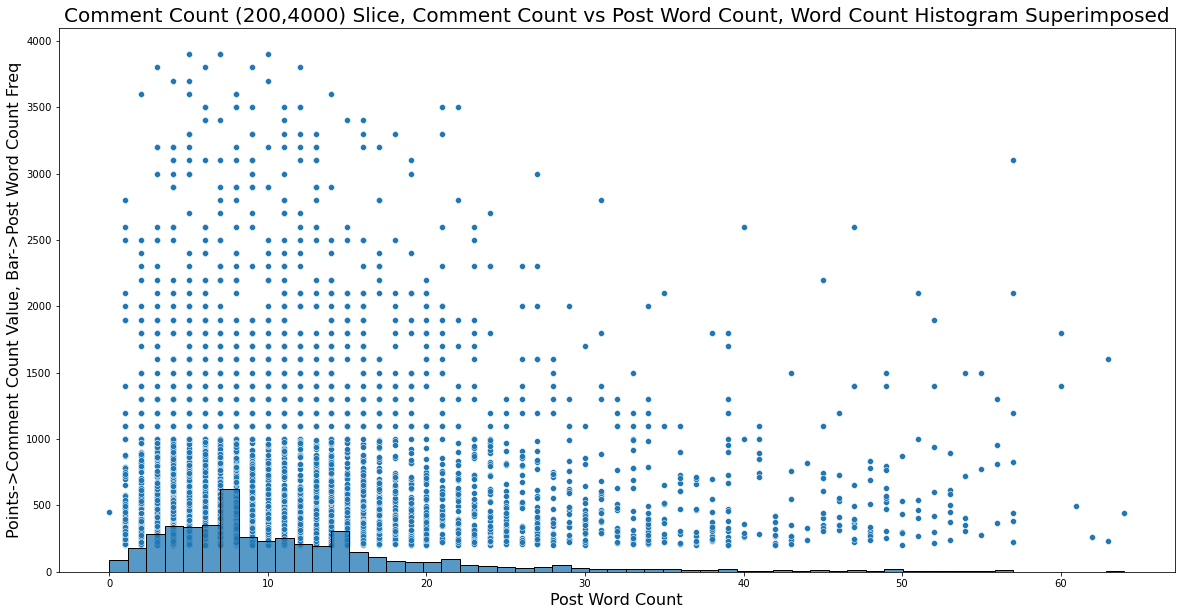

In [222]:
plt.figure(figsize = (20,10))
sns.scatterplot(data=df_reddit_c[(df_reddit_c['comment_count']<4000)&(df_reddit_c['comment_count']>200)], x="post_word_count", y="comment_count")
sns.histplot(data=df_reddit_c[(df_reddit_c['comment_count']<4000)&(df_reddit_c['comment_count']>200)],x='post_word_count')
plt.title('Comment Count (200,4000) Slice, Comment Count vs Post Word Count, Word Count Histogram Superimposed',size=20)
plt.xlabel('Post Word Count',size=16)
plt.ylabel('Points->Comment Count Value, Bar->Post Word Count Freq',size=16);

This was just for my own visualization of whats going on between these two features

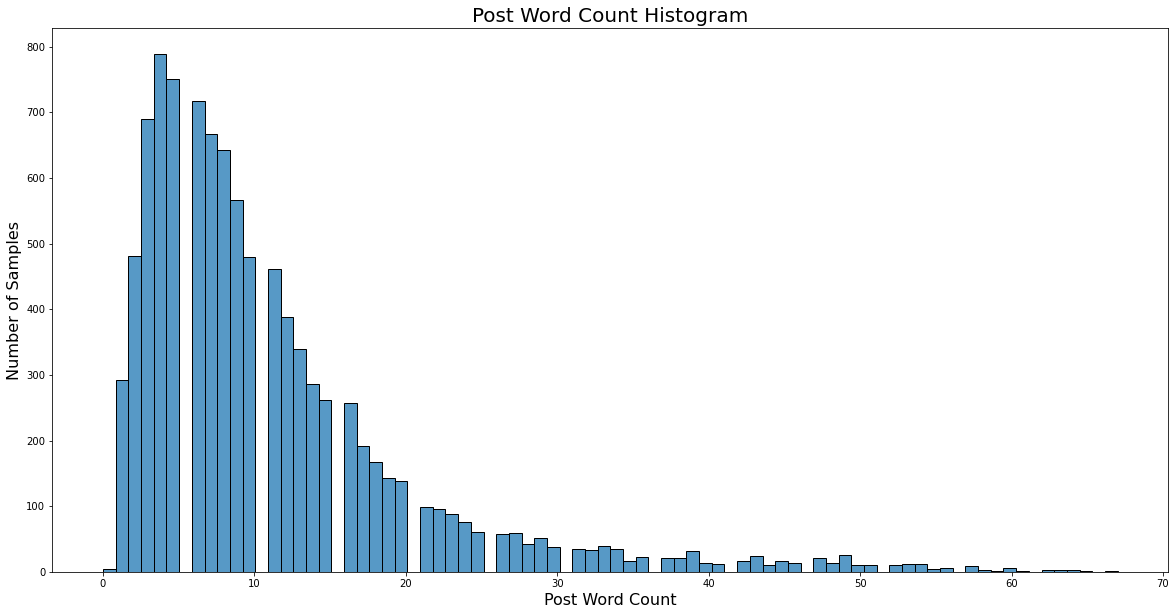

In [224]:
plt.figure(figsize = (20,10))
sns.histplot(data=df_reddit_c,x='post_word_count')
plt.title('Post Word Count Histogram',size=20)
plt.xlabel('Post Word Count',size=16)
plt.ylabel('Number of Samples',size=16);

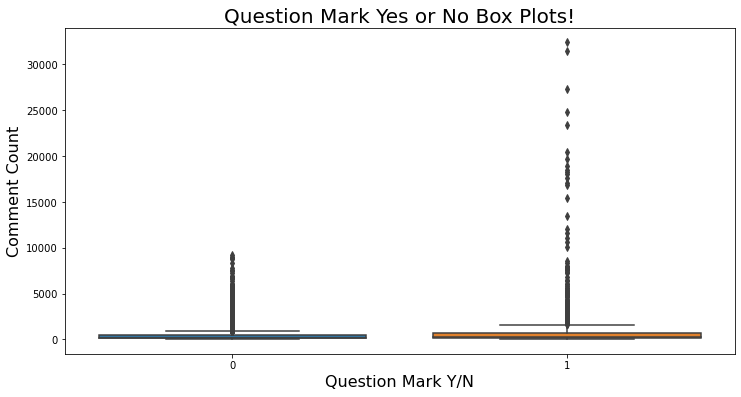

In [236]:
plt.figure(figsize = (12,6))
sns.boxplot(x="question_mark", y="comment_count", data=df_reddit_c);
plt.title('Question Mark Yes or No Box Plots!',size=20)
plt.xlabel('Question Mark Y/N',size=16)
plt.ylabel('Comment Count',size=16);

Despite this metric skewing above the average mean of the sample for the positive case, only ~12% of the sample set has a '?' in the thread title.

Going to try using it as a feature to see if it improves model performance

In [70]:
df_reddit_c[df_reddit_c['emoji']==1].comment_count.mean()

282.8733153638814

Emoji's make up less then 4% of the data set and additionally they are 

**Cleaned dataframe summary stats -**

In [71]:
df_reddit_c.describe().T

,count,mean,std,min,25%,50%,75%,max
comment_count,9896.0,490.638339,1163.278826,51.0,109.0,200.0,459.0,32400.0
upvote_delta,9896.0,9654.754244,13053.764382,350.0,2200.0,4800.0,11300.0,132000.0
timeup_list,9896.0,10.093169,4.316439,2.0,7.0,10.0,13.0,24.0
question_mark,9896.0,0.116916,0.321336,0.0,0.0,0.0,0.0,1.0
emoji,9896.0,0.037490,0.189969,0.0,0.0,0.0,0.0,1.0
polarity,9896.0,0.048508,0.260802,-1.0,0.0,0.0,0.1,1.0
subjectivity,9896.0,0.275844,0.327287,0.0,0.0,0.1,0.5,1.0
post_word_count,9896.0,11.112470,9.596360,0.0,5.0,8.0,14.0,67.0


In summary of added features, post word counts on average are around the length of a article title you would see in a newspaper.  Because titles can get very lengthy, there is high standard deviation.

Emoji's make up less than 4% of the thread titles.  Would love to see that compared to twitter and TikTok high traction posts.

Polarity is mostly neutral, slightly leaning positive.  As we move towards the bounds of -1 and 1 we see higher average comments (negative polarity being higher then positive sadly)

Subjectivity returned that most posts were more on the factual end, but there was not a clear cut trend in effect on comment count for the post

Question marks were present in highly performing posts, its no wonder you see posts on twitter from groups or organizations asking straightforward questions on topics.  It gets easy consumer interaction/engagement.

**Scaling post word count**

In [72]:
df_reddit_d=df_reddit_c.copy(deep=True)

In [73]:
pwc_mean=np.mean(df_reddit_c['post_word_count'])
pwc_std=np.std(df_reddit_c['post_word_count'])

In [74]:
df_reddit_d['post_word_count']=df_reddit_d['post_word_count'].apply(lambda x: (x-pwc_mean)/pwc_std)

In [75]:
df_reddit_d.describe().T

,count,mean,std,min,25%,50%,75%,max
comment_count,9896.0,4.906383e+02,1163.278826,51.000000,109.000000,200.000000,459.000000,32400.00000
upvote_delta,9896.0,9.654754e+03,13053.764382,350.000000,2200.000000,4800.000000,11300.000000,132000.00000
timeup_list,9896.0,1.009317e+01,4.316439,2.000000,7.000000,10.000000,13.000000,24.00000
question_mark,9896.0,1.169159e-01,0.321336,0.000000,0.000000,0.000000,0.000000,1.00000
emoji,9896.0,3.748989e-02,0.189969,0.000000,0.000000,0.000000,0.000000,1.00000
polarity,9896.0,4.850784e-02,0.260802,-1.000000,0.000000,0.000000,0.100000,1.00000
subjectivity,9896.0,2.758438e-01,0.327287,0.000000,0.000000,0.100000,0.500000,1.00000
post_word_count,9896.0,-2.210798e-16,1.000051,-1.158046,-0.636989,-0.324355,0.300914,5.82412


Scaling word count just to make life easier in modeling since the other values are all scaled to some degree already.

### EDA: Random Forest test model and additional insight

In [76]:
df_reddit['high_low_onehot']=df_reddit['comment_count'].map(lambda x: 1 if x>200 else 0)

In [77]:
df_reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9896 entries, 0 to 12123
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   comment_count    9896 non-null   float64
 1   upvote_delta     9896 non-null   float64
 2   timeup_list      9896 non-null   float64
 3   subreddit        9896 non-null   object 
 4   thread_text      9896 non-null   object 
 5   high_low_onehot  9896 non-null   int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 541.2+ KB


In [78]:
df_reddit['high_low_onehot'].mean()

0.4989894907033145

The majority class is therefore the low comment count threads, which is everything under 200 count.

In [79]:
df_reddit_dum=pd.get_dummies(df_reddit,columns=['subreddit'],drop_first=True)

creating a dummified dataframe of the subreddits

In [80]:
df_reddit_dum.columns

Index(['comment_count', 'upvote_delta', 'timeup_list', 'thread_text',
       'high_low_onehot', 'subreddit_r/196', 'subreddit_r/2007scape',
       'subreddit_r/2meirl42meirl4meirl', 'subreddit_r/2meirl4meirl',
       'subreddit_r/2visegrad4you',
       ...
       'subreddit_r/xboxone', 'subreddit_r/xmen', 'subreddit_r/xqcow',
       'subreddit_r/yakuzagames', 'subreddit_r/yesyesyesno',
       'subreddit_r/yesyesyesyesno', 'subreddit_r/youngpeopleyoutube',
       'subreddit_r/youseeingthisshit', 'subreddit_r/yugioh',
       'subreddit_r/zelda'],
      dtype='object', length=1203)

In [81]:
df_reddit_dum.columns[0:5]

Index(['comment_count', 'upvote_delta', 'timeup_list', 'thread_text',
       'high_low_onehot'],
      dtype='object')

In [82]:
sub_list=list(df_reddit_dum.columns[5:])

**Setting up model**

In [106]:
Xr=df_reddit_dum[sub_list]
yr=df_reddit_dum['high_low_onehot']

In [107]:
Xr.shape

(9896, 1198)

In [108]:
yr.shape

(9896,)

In [190]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

**Random Forest instan**

In [287]:
clf = RandomForestClassifier(max_depth=50, random_state=13)
clfval = RandomForestClassifier(max_depth=50, random_state=13)

In [288]:
clf.fit(Xr,yr)

RandomForestClassifier(max_depth=100, random_state=13)

In [289]:
scores1=cross_val_score(clfval,Xr,yr,cv=4)

In [290]:
round(scores1.mean(), 2), '+-', round(2 * scores1.std(), 2)

(0.66, '+-', 0.02)

This is an improvement over our baseline!

In [114]:
pd.Series(data=clf.feature_importances_,index=list(Xr.columns))

subreddit_r/196                    0.0
subreddit_r/2007scape              0.0
subreddit_r/2meirl42meirl4meirl    0.0
subreddit_r/2meirl4meirl           0.0
subreddit_r/2visegrad4you          0.0
                                  ... 
subreddit_r/yesyesyesyesno         0.0
subreddit_r/youngpeopleyoutube     0.0
subreddit_r/youseeingthisshit      0.0
subreddit_r/yugioh                 0.0
subreddit_r/zelda                  0.0
Length: 1198, dtype: float64

In [115]:
subs_import_list=[]
for x11 in list(Xr.columns):
    subs_import_list.append(x11.lstrip('subreddit').lstrip('_'))

In [116]:
pred_ser1=pd.Series(data=clf.feature_importances_,index=subs_import_list)

using the list of subs combining it with the feature importances to see any relation between the feature importance, subreddit, obs count and comment mean

In [117]:
r13or30=pd.Series([0],index=['r/13or30'])  #left this one out, bringing it back for df and setting to 0

In [118]:
pred_ser1=pd.concat([pred_ser1,r13or30])

In [119]:
df_trees=df_reddit.copy(deep=True)

In [120]:
df_trees['rating']=df_trees['subreddit'].apply(lambda x: pred_ser1[x])

In [121]:
pred_ser1.sort_values(ascending=False).head(10)

r/antiwork              0.062155
r/WhitePeopleTwitter    0.042875
r/news                  0.042159
r/teenagers             0.039021
r/politics              0.035165
r/Tinder                0.030582
r/facepalm              0.028449
r/worldnews             0.027380
r/nba                   0.026021
r/HermanCainAward       0.025680
dtype: float64

Looking at the important subreddits

In [122]:
df_1=df_trees.groupby(['subreddit','rating'])['comment_count'].count()

In [123]:
df_1.rename('obs_num',inplace=True);

In [124]:
df_2=df_trees.groupby(['subreddit','rating'])['comment_count'].mean()

In [125]:
df_2.rename('mean comments',inplace=True);

need to do a concat of groupbys to get the desired table

In [126]:
df_3=pd.concat([df_1,df_2],axis=1)

**Summary statistics of subreddits with large sample counts**

In [127]:
df_3.sort_values('obs_num',ascending=False).head(20)

,,obs_num,mean comments
subreddit,rating,,
r/antiwork,0.062155,72,1603.000000
r/MadeMeSmile,0.000000,68,516.661765
r/nextfuckinglevel,0.006815,63,785.412698
r/Damnthatsinteresting,0.000000,60,705.483333
r/interestingasfuck,0.000000,59,795.237288
r/Unexpected,0.000000,58,576.448276
r/facepalm,0.028449,57,1556.456140
r/memes,0.002632,57,537.982456
r/WhitePeopleTwitter,0.042875,56,1275.428571


The rating is the feature importance from the Random Forest test model, all comment counts are above the 200 median mark.

75th percentile is ~460 comments and most of these subreddit's average comment count is above that value.

In [128]:
df_cl=df_3.reset_index()

In [129]:
df_cl.set_index('subreddit',inplace=True)

In [130]:
df_cl.drop(columns='rating',inplace=True)

In [131]:
df_cl.sort_values(by='obs_num',ascending=False).head(10)

,obs_num,mean comments
subreddit,,
r/antiwork,72,1603.000000
r/MadeMeSmile,68,516.661765
r/nextfuckinglevel,63,785.412698
r/Damnthatsinteresting,60,705.483333
r/interestingasfuck,59,795.237288
r/Unexpected,58,576.448276
r/facepalm,57,1556.456140
r/memes,57,537.982456
r/WhitePeopleTwitter,56,1275.428571


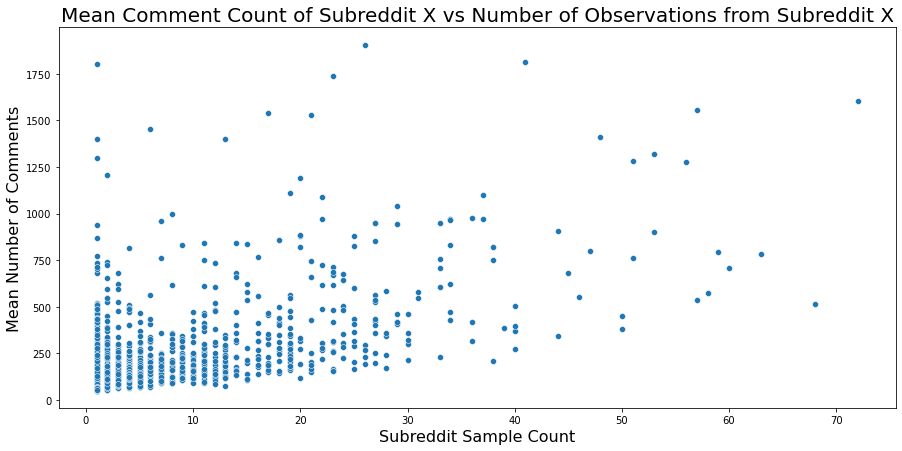

In [233]:
plt.figure(figsize = (15,7))
sns.scatterplot(data=df_cl[df_cl['mean comments']<2000], x="obs_num", y="mean comments")
plt.title('Mean Comment Count of Subreddit X vs Number of Observations from Subreddit X',size=20)
plt.xlabel('Subreddit Sample Count',size=16)
plt.ylabel('Mean Number of Comments',size=16);

In [234]:
print('Unqiue subreddits in dataset:', df_3.shape[0])
print('Median number of times a subreddit appeared in the cleaned datafrme:',df_3['obs_num'].median())
print('Mean number of times a subreddit appeared in the cleaned datafrme:',df_3['obs_num'].mean())

Unqiue subreddits in dataset: 1199
Median number of times a subreddit appeared in the cleaned datafrme: 4.0
Mean number of times a subreddit appeared in the cleaned datafrme: 8.253544620517097


The median frequency of a subreddit in the sample set is 4 and the average is over 8.

In [201]:
print('Subreddits above median:',df_3[df_3['obs_num']>4].shape[0])
print('Subreddits above mean:',df_3[df_3['obs_num']>8].shape[0])

Subreddits above median: 548
Subreddits above mean: 384


There are 548 different subreddits above the median subreddit occurrance frequency and 384 above the mean.

In [202]:
print('Reprinting total cleaned samples:',df_3.obs_num.sum())
print('Samples above mean:',df_3[df_3['obs_num']>8].obs_num.sum())

Reprinting total cleaned samples: 9896
Samples above mean: 7660


Of the 9896 samples being looked at, 7670 of them are from subreddits that have more then 8 appearances in the data.

In [204]:
print('Subreddits with more then 18 samples in the cleaned dataset:',df_3[df_3['obs_num']>18].shape[0])
print('Percent of the samples that these subreddits make up of the cleaned dataset:',(df_3[df_3['obs_num']>18].obs_num.sum()/df_3.obs_num.sum()))
print('Comment count mean for subreddits with more then 18 samples:',round(df_3[df_3['obs_num']>18]['mean comments'].mean(),2))

Subreddits with more then 18 samples in the cleaned dataset: 167
Percent of the samples that these subreddits make up of the cleaned dataset: 0.4989894907033145
Comment count mean for subreddits with more then 18 samples: 640.66


Overall what can be seen from this, about half the samples collected come from 167 different subreddits and the average comment count of these subreddits is ~640.

This is well above our current baseline metric so even though this is not in a model this is good insight for future changes should more work be done.

## Using CountVectorizer and Final Models

In [181]:
cvec1 = CountVectorizer(stop_words='english')
cvec1.fit(df_reddit_c['thread_text_clean'])

CountVectorizer(stop_words='english')

Using the non-stemmed words in this one

In [182]:
df_CVtext_1 = pd.DataFrame(cvec1.transform(df_reddit_c['thread_text_clean']).todense(),
                        columns=cvec1.get_feature_names())

In [189]:
df_CVtext_1.sum().nlargest(10)

just         393
like         324
new          301
christmas    268
people       221
got          218
year         205
time         189
years        178
im           175
dtype: int64

In [184]:
mnb_clf=MultinomialNB()  

In [185]:
Xmnb=df_CVtext_1
ymnb=df_reddit_dum['high_low_onehot']

In [191]:
scores_mnb=cross_val_score(mnb_clf,Xmnb,ymnb,cv=KFold(n_splits=5, shuffle=True,random_state=13))

**Mulitnominal Naive Bayes with Countvectorizer**

In [192]:
round(scores_mnb.mean(), 2), '+-', round(2 * scores_mnb.std(), 2)

(0.57, '+-', 0.01)

Pretty good score using Multinominal

In [175]:
tvec = TfidfVectorizer(stop_words='english',strip_accents = 'ascii',norm='l1')
tvec.fit(df_reddit_c['stemmed_thread'])

TfidfVectorizer(norm='l1', stop_words='english', strip_accents='ascii')

In [176]:
df_TVtext = pd.DataFrame(tvec.transform(df_reddit_c['stemmed_thread']).todense(),
                        columns=tvec.get_feature_names())

In [177]:
df_TVtext.sum().nlargest(15)

thi         115.667930
nt           60.572843
just         42.379822
like         38.823695
wa           35.329131
year         34.765903
christma     34.148748
new          31.927443
did          28.749935
time         27.999224
got          27.983229
whi          26.991325
think        26.503721
guy          26.209007
know         26.144218
dtype: float64

In [178]:
Xkn=df_TVtext
ykn=df_reddit_dum['high_low_onehot']

In [198]:
scores_Tfidf_mnb=cross_val_score(mnb_clf,Xkn,ykn,cv=KFold(n_splits=5, shuffle=True,random_state=13))

**Mulitnominal Naive Bayes with Tfidf**

In [199]:
round(scores_Tfidf_mnb.mean(), 2), '+-', round(2 * scores_Tfidf_mnb.std(), 2)

(0.56, '+-', 0.01)

This is an improvement over when I tried KNN

I am commenting the below lines out just because these took a while to run, feel free to uncomment and run but its around 55% accuracy with depth 50, the value below is with 100 depth to get a score ~57%

In [291]:
#scores3=cross_val_score(clfval,Xkn,ykn,cv=KFold(n_splits=5, shuffle=True,random_state=13))

In [292]:
#round(scores3.mean(), 2), '+-', round(2 * scores3.std(), 2)

(0.57, '+-', 0.02)

In [238]:
df_reddit_d.columns

Index(['comment_count', 'upvote_delta', 'timeup_list', 'subreddit',
       'thread_text', 'question_mark', 'thread_text_clean', 'emoji',
       'polarity', 'subjectivity', 'stemmed_thread', 'post_word_count'],
      dtype='object')

In [241]:
df_d=df_reddit_d[['question_mark','emoji','polarity','subjectivity','post_word_count']]

In [258]:
Xrnew=pd.concat([df_d,Xr],axis=1)

In [280]:
clfnew = RandomForestClassifier(max_depth=100, random_state=13)

In [281]:
scoresfc=cross_val_score(clfnew,Xrnew,yr,cv=4)

**Random Trees with Additional Features**

In [282]:
round(scoresfc.mean(), 2), '+-', round(2 * scoresfc.std(), 2)

(0.66, '+-', 0.0)

66% accuracy of classification, on average 16 percent greater then our baseline accuracy

and the winner is...

### Random Tree Classifier with a max depth of 100, Model Accuracy of 66 +- 0 %

extra features seem to help improve the model's overall +- vs just running the subreddits.  Subreddit feature still clearly doing most of the work

The subreddit feature was the strongest, having an ensemble fit probably helps with misclassification issues that occur due to the large number of subreddits in the data set.

## Plots

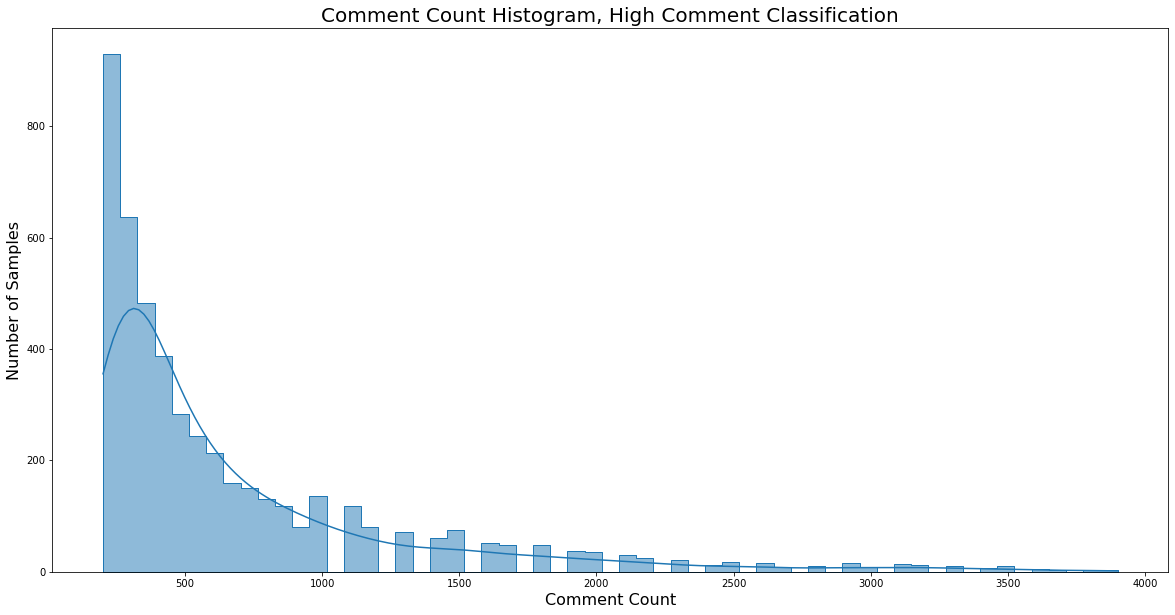

In [341]:
plt.figure(figsize = (20,10))
sns.histplot(df_reddit_c[(df_reddit_c['comment_count']>200) & (df_reddit_c['comment_count']<4000)],x='comment_count',element='step',kde=True)
plt.title('Comment Count Histogram, High Comment Classification',size=20)
plt.xlabel('Comment Count',size=16)
plt.ylabel('Number of Samples',size=16);

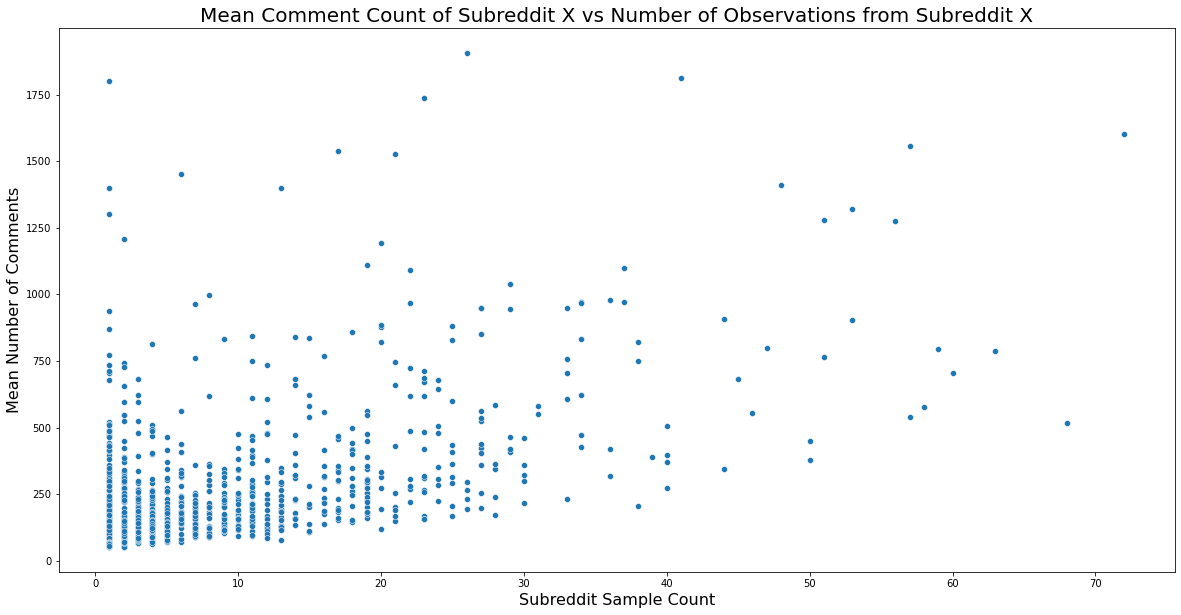

In [342]:
plt.figure(figsize = (20,10))
sns.scatterplot(data=df_cl[df_cl['mean comments']<2000], x="obs_num", y="mean comments")
plt.title('Mean Comment Count of Subreddit X vs Number of Observations from Subreddit X',size=20)
plt.xlabel('Subreddit Sample Count',size=16)
plt.ylabel('Mean Number of Comments',size=16);

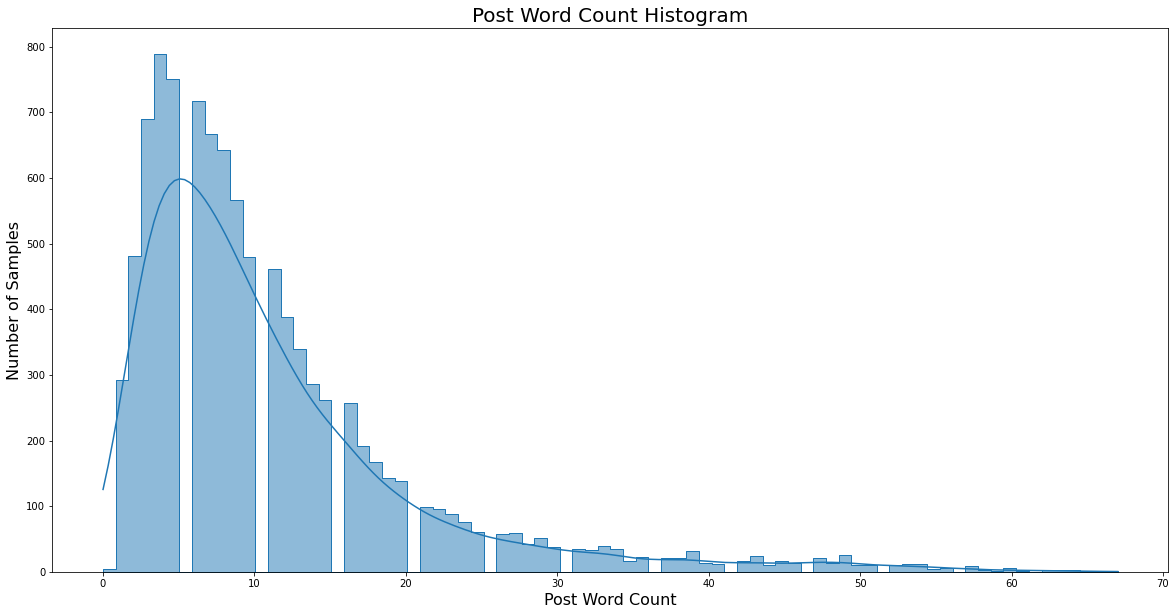

In [343]:
plt.figure(figsize = (20,10))
sns.histplot(data=df_reddit_c,x='post_word_count',element='step',kde=True)
plt.title('Post Word Count Histogram',size=20)
plt.xlabel('Post Word Count',size=16)
plt.ylabel('Number of Samples',size=16);